# Autometic Judgment Analysis

In [22]:
import pandas as pd
import numpy as np
import requests
import tarfile
import json
import gzip
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [9]:
nist_qrel_file = 'qrels/2023.qrels.pass.withDupes.txt'
gpt4_qrel_file = 'qrels/2023.qrels.pass.gpt4.txt'
dl_2023_queries = "dl-2023-queries.tsv"

## Loading Judgments

In [10]:
# loading judged queries
nist_qrels = pd.read_csv(nist_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])
# loading judged queries - GPT-4
gpt4_qrels = pd.read_csv(gpt4_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

In [11]:
nist_qrels.groupby('qid')['qid'].agg('count')

qid
2001010    223
2001459    374
2001575    191
2002075    270
2002168    483
          ... 
3100825    173
3100833    224
3100909    337
3100918    217
3100922    190
Name: qid, Length: 82, dtype: int64

In [12]:
queries_judged = set(nist_qrels['qid'])
docids = set(nist_qrels['docid'])

In [13]:
real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

In [14]:
queries = pd.read_csv(dl_2023_queries, sep='\t', header=None, names=['qid', 'qtext'])
queries.head()

,qid,qtext
0,2000138,How does the process of digestion and metaboli...
1,2000438,apatite definition
2,2000727,calculate salary from basic pay
3,2000882,cerebellar disease definition
4,2001010,cost comparison of funerals in australia


## Loading Documents

In [9]:
def read_bundles(bundlenum):
     with gzip.open(f'msmarco_v2_passage/msmarco_passage_{bundlenum}.gz','r') as fpassage:
          for passage in fpassage:
            json_passage = json.loads(passage.decode('utf8'))
            if json_passage['pid'] in docids:
                docid_to_passage[json_passage['pid']] = json_passage['passage']

In [10]:
# read TREC passagess
docid_to_passage = {}

for bundlenum in tqdm(range(0, 70)):
    if bundlenum < 10:
        bundlenum = f'0{str(bundlenum)}'
    read_bundles(bundlenum=bundlenum)

100%|██████████| 70/70 [08:05<00:00,  6.93s/it]


In [14]:
more_relevant_by_nist_qids = set()
more_relevant_by_nist_docids = set()

more_relevant_by_llm_qids = set()
more_relevant_by_llm_docids = set()

equal_qids = set()
equal_docids = set()

In [79]:
all_docis_len = []
for nist_qrel, llm_qrel in zip(nist_qrels.itertuples(index=True), gpt4_qrels.itertuples(index=True)):
    all_docis_len.append(get_doc_length(docid_to_passage[nist_qrel.docid]))
    if nist_qrel.qid == llm_qrel.qid:
        if nist_qrel.qid in (t5_queries_judged + gpt4_queries_judged):
            if nist_qrel.docid == llm_qrel.docid:
                if nist_qrel.rel != llm_qrel.rel:
                    # llm gives lower score
                    if nist_qrel.rel > llm_qrel.rel:
                        more_relevant_by_nist_qids.add(nist_qrel.qid)
                        more_relevant_by_nist_docids.add(nist_qrel.docid)
                    # llm gives higher score
                    elif nist_qrel.rel < llm_qrel.rel:
                        more_relevant_by_llm_qids.add(nist_qrel.qid)
                        more_relevant_by_llm_docids.add(nist_qrel.docid)
                else:
                    equal_qids.add(nist_qrel.qid)
                    equal_docids.add(nist_qrel.docid)
            else:
                print("No equal docid.")
    else:
        print("Not equal qid.")

Pearson correlation: -0.0008368717016563407, p-value: 0.9004916864290091
Spearman correlation: -0.005840684828172393, p-value: 0.3828338812110311


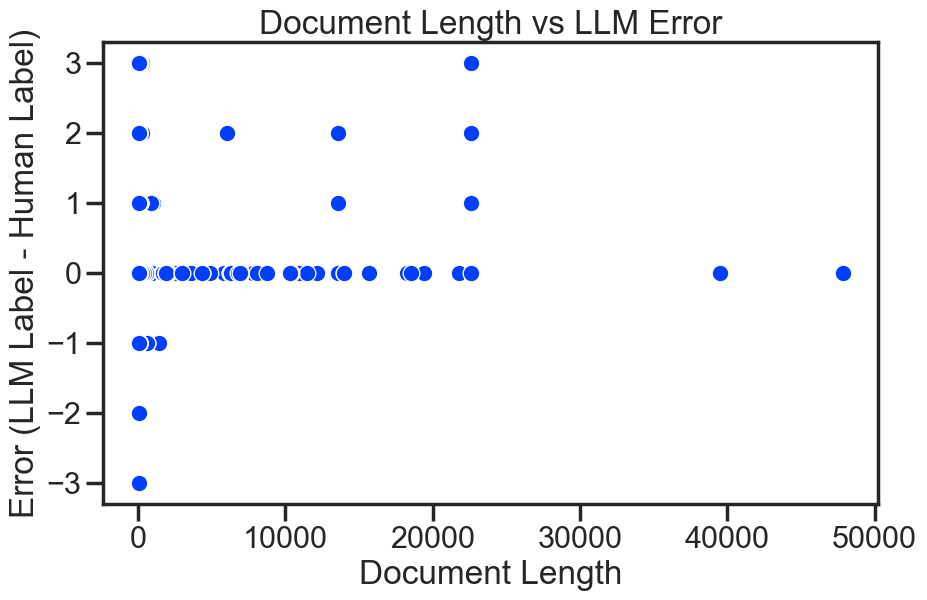

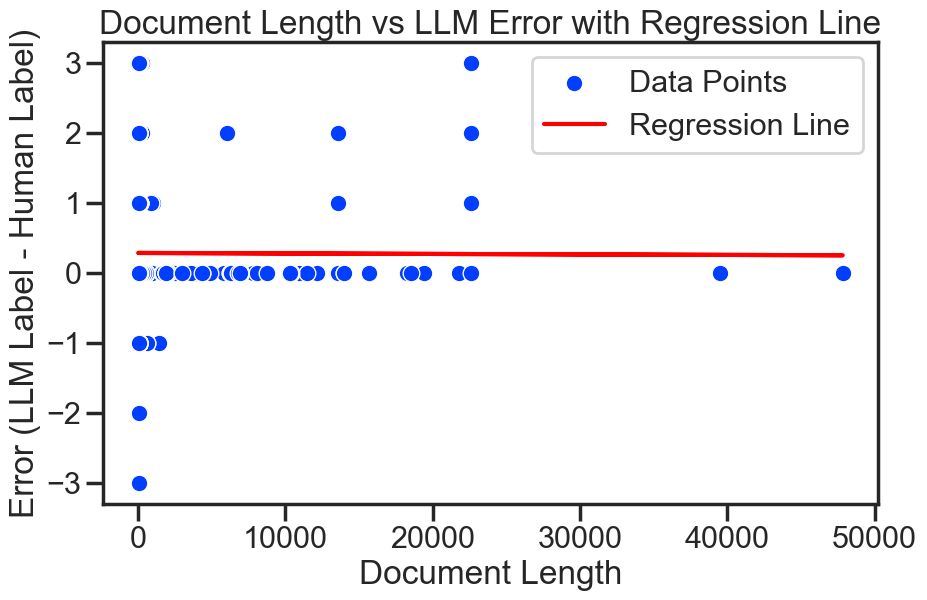

Regression Coefficient: -6.971172252446543e-07
Intercept: 0.2832116707543649


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

# Example DataFrame creation
data = {
    'human_label': nist_qrels['rel'],
    'llm_label': gpt4_qrels['rel'],
    'document_length': all_docis_len
}

df = pd.DataFrame(data)

# Step 1: Calculate Errors
df['error'] = df['llm_label'] - df['human_label']

# Step 2: Correlation Analysis
# Pearson correlation
pearson_corr, pearson_pval = pearsonr(df['error'], df['document_length'])

# Spearman correlation
spearman_corr, spearman_pval = spearmanr(df['error'], df['document_length'])

print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_pval}")
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pval}")

# Step 3: Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='document_length', y='error', data=df)
plt.title('Document Length vs LLM Error')
plt.xlabel('Document Length')
plt.ylabel('Error (LLM Label - Human Label)')
plt.show()

# Step 4: Regression Analysis
# Reshape document_length for sklearn LinearRegression
X = df['document_length'].values.reshape(-1, 1)
y = df['error'].values

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Get regression predictions
y_pred = model.predict(X)

# Plot regression line with scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='document_length', y='error', data=df, label='Data Points')
plt.plot(df['document_length'], y_pred, color='red', label='Regression Line')
plt.title('Document Length vs LLM Error with Regression Line')
plt.xlabel('Document Length')
plt.ylabel('Error (LLM Label - Human Label)')
plt.legend()
plt.show()

# Print regression coefficients
print(f"Regression Coefficient: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")


In [16]:
len(more_relevant_by_llm_docids), len(more_relevant_by_nist_docids)

(2623, 943)

In [17]:
unique_llm_more_relevant = (more_relevant_by_llm_docids - more_relevant_by_nist_docids) - equal_docids
unique_nist_more_relevant = (more_relevant_by_nist_docids - more_relevant_by_llm_docids) - equal_docids

In [18]:
len(unique_llm_more_relevant), len(unique_nist_more_relevant)

(2526, 855)

In [20]:
def get_doc_length(passage):
    passage_len = len(passage.split(' '))
    return passage_len

In [36]:
def get_avg_len(document_list):
    docids_len = []
    for eachitem in document_list:
        doc_len = get_doc_length(docid_to_passage[eachitem])
        docids_len.append(doc_len)
    print(sum(docids_len) / len(document_list))
    return docids_len


In [69]:
llm_docids_len = get_avg_len(unique_llm_more_relevant)
nist_docids_len = get_avg_len(unique_nist_more_relevant)
equal_docids_len = get_avg_len(equal_docids)

51.486144101346
52.32631578947368
144.90474009617586


In [73]:
# Combine the lists to find the global min and max
combined = equal_docids_len + llm_docids_len

min_value = min(combined)
max_value = max(combined)

# Define a function to normalize a list
def normalize_list(data, min_val, max_val):
    return [(x - min_val) / (max_val - min_val) * 100 for x in data]

# Normalize both lists
normalized_list1 = normalize_list(equal_docids_len, min_value, max_value)
normalized_list2 = normalize_list(llm_docids_len, min_value, max_value)

# Output the normalized lists
# normalized_list1, normalized_list2


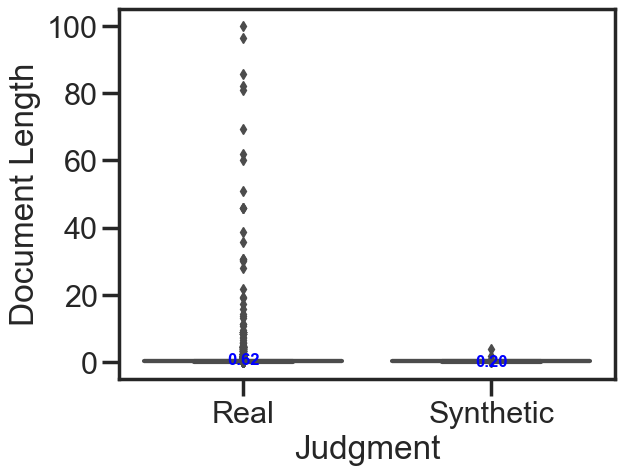

In [74]:
# Set the aesthetic style of the plots
sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster")     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

# Sample data
data1 = normalized_list1
data2 = normalized_list2

# Prepare the data
data = pd.DataFrame({
    'Values': data1 + data2,
    'Category': ['Real'] * len(data1) + ['Synthetic'] * len(data2)
})

# Calculate the mean for each category
mean_values = data.groupby('Category')['Values'].mean()

# Create the box plot
# sns.set(style="whitegrid")
ax = sns.boxplot(x='Category', y='Values', data=data)

# Annotate the mean values on the plot
for i, category in enumerate(mean_values.index):
    mean_value = mean_values[category]
    ax.text(i, mean_value, f'{mean_value:.2f}', color='blue', ha='center', va='center', fontsize=12, fontweight='bold')

# Add a title
# plt.title('Box Plot with Mean Values Annotated')
plt.ylabel("Document Length")
plt.xlabel("Judgment")

# Show the plot
plt.show()


In [68]:
len(more_relevant_by_llm_qids), len(more_relevant_by_nist_qids)

(81, 81)

- for all queries made the wrong prediction

In [69]:
len(equal_qids)

82

1. Getting average document length

In [17]:
def get_query_length(query_text):
    query_len = len(query_text.split(' '))
    if query_len >= 10:
        # long query == 1
        query_len_type = 1
    else:
        # short query == 0
        query_len_type = 0
    return query_len_type, query_len

In [16]:
def get_doc_length(passage):
    passage_len = len(passage.split(' '))
    return passage_len

In [18]:
passages_len = []
for eachline in nist_qrels.itertuples(index=True):
        doc_len = get_doc_length(docid_to_passage[eachline.docid])
        passages_len.append(doc_len)

In [26]:
len(passages_len)

22327

In [21]:
np.average(passages_len)

145.6498857885072

In [27]:
c = 0
for passage_len in passages_len:
    if passage_len > 50:
        c+=1
print(c)

11577


## Bland Altman Plot

In [16]:
# Set the aesthetic style of the plots
sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_context("poster")     # Options: paper, notebook, talk, poster
sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

Bias (Mean Difference): -0.28


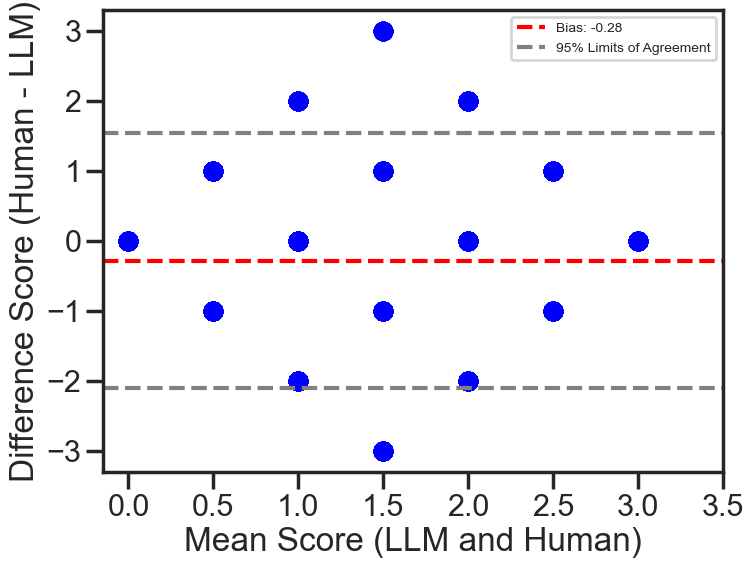

In [23]:
# Example categorical relevance scores (human and LLM)
human_scores = nist_qrels['rel']
llm_scores = gpt4_qrels['rel']

# Calculate the differences between human and LLM scores
diff_scores = human_scores - llm_scores

# Calculate the bias (mean difference)
bias = np.mean(diff_scores)

# Print the bias
print(f'Bias (Mean Difference): {bias:.2f}')

# Bland-Altman Plot function
def bland_altman_plot(data1, data2):
    mean_scores = np.mean([data1, data2], axis=0)
    diff_scores = data1 - data2
    mean_diff = np.mean(diff_scores)
    std_diff = np.std(diff_scores)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_scores, diff_scores, color='blue', alpha=0.5)
    plt.axhline(mean_diff, color='red', linestyle='--', label=f'Bias: {mean_diff:.2f}')
    plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='95% Limits of Agreement')
    plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--')
    # plt.title('Bland-Altman Plot for Categorical Scores')
    plt.xlabel('Mean Score (LLM and Human)')
    plt.ylabel('Difference Score (Human - LLM)')
    plt.yticks(np.arange(-3, 4, step=1))
    plt.xticks(np.arange(0, 4, step=0.5))
    plt.legend(fontsize=10)
    # plt.savefig("figs/bland_altman_plot_scores.pdf", bbox_inches="tight")
    plt.show()

# Run the Bland-Altman Plot
bland_altman_plot(human_scores, llm_scores)


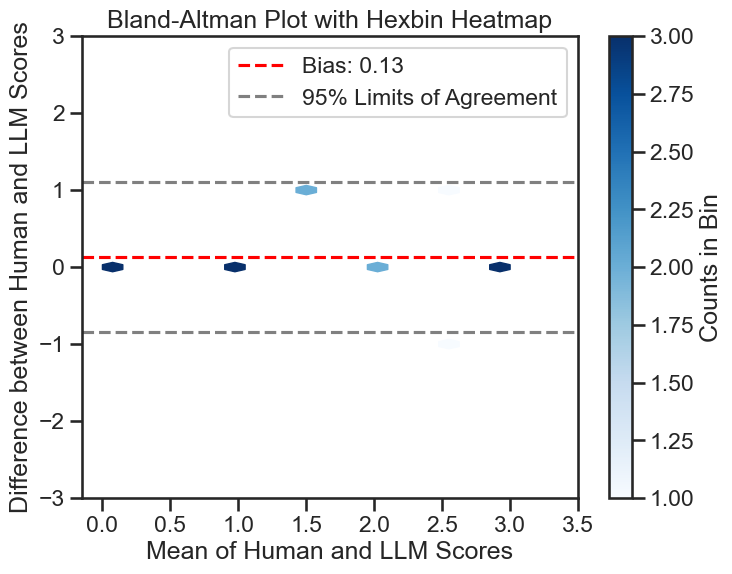

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Example categorical relevance scores (human and LLM)
human_scores = np.array([0, 1, 2, 2, 3, 1, 0, 2, 3, 1, 3, 0, 2, 2, 3])
llm_scores = np.array([0, 1, 1, 2, 2, 1, 0, 3, 3, 1, 3, 0, 2, 1, 3])

# Calculate the differences between human and LLM scores
diff_scores = human_scores - llm_scores
mean_scores = np.mean([human_scores, llm_scores], axis=0)

# Bland-Altman Plot with hexbin
plt.figure(figsize=(8, 6))
plt.hexbin(mean_scores, diff_scores, gridsize=20, cmap='Blues', mincnt=1)
plt.colorbar(label='Counts in Bin')
plt.axhline(np.mean(diff_scores), color='red', linestyle='--', label=f'Bias: {np.mean(diff_scores):.2f}')
plt.axhline(np.mean(diff_scores) + 1.96 * np.std(diff_scores), color='gray', linestyle='--', label='95% Limits of Agreement')
plt.axhline(np.mean(diff_scores) - 1.96 * np.std(diff_scores), color='gray', linestyle='--')
plt.title('Bland-Altman Plot with Hexbin Heatmap')
plt.xlabel('Mean of Human and LLM Scores')
plt.ylabel('Difference between Human and LLM Scores')
plt.yticks(np.arange(-3, 4, step=1))
plt.xticks(np.arange(0, 4, step=0.5))
plt.legend()
plt.show()


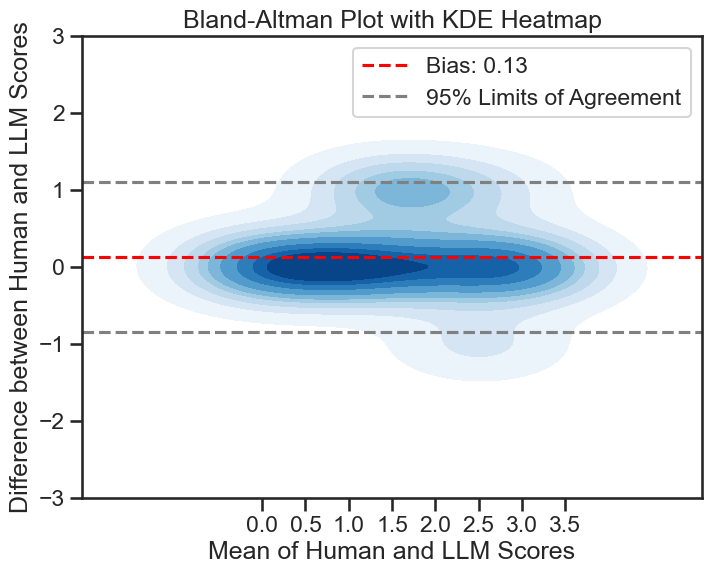

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example categorical relevance scores (human and LLM)
human_scores = np.array([0, 1, 2, 2, 3, 1, 0, 2, 3, 1, 3, 0, 2, 2, 3])
llm_scores = np.array([0, 1, 1, 2, 2, 1, 0, 3, 3, 1, 3, 0, 2, 1, 3])

# Calculate the differences between human and LLM scores
diff_scores = human_scores - llm_scores
mean_scores = np.mean([human_scores, llm_scores], axis=0)

# Bland-Altman Plot with KDE
plt.figure(figsize=(8, 6))
sns.kdeplot(x=mean_scores, y=diff_scores, fill=True, cmap='Blues')
plt.axhline(np.mean(diff_scores), color='red', linestyle='--', label=f'Bias: {np.mean(diff_scores):.2f}')
plt.axhline(np.mean(diff_scores) + 1.96 * np.std(diff_scores), color='gray', linestyle='--', label='95% Limits of Agreement')
plt.axhline(np.mean(diff_scores) - 1.96 * np.std(diff_scores), color='gray', linestyle='--')
plt.title('Bland-Altman Plot with KDE Heatmap')
plt.xlabel('Mean of Human and LLM Scores')
plt.ylabel('Difference between Human and LLM Scores')
plt.yticks(np.arange(-3, 4, step=1))
plt.xticks(np.arange(0, 4, step=0.5))
plt.legend()
plt.show()


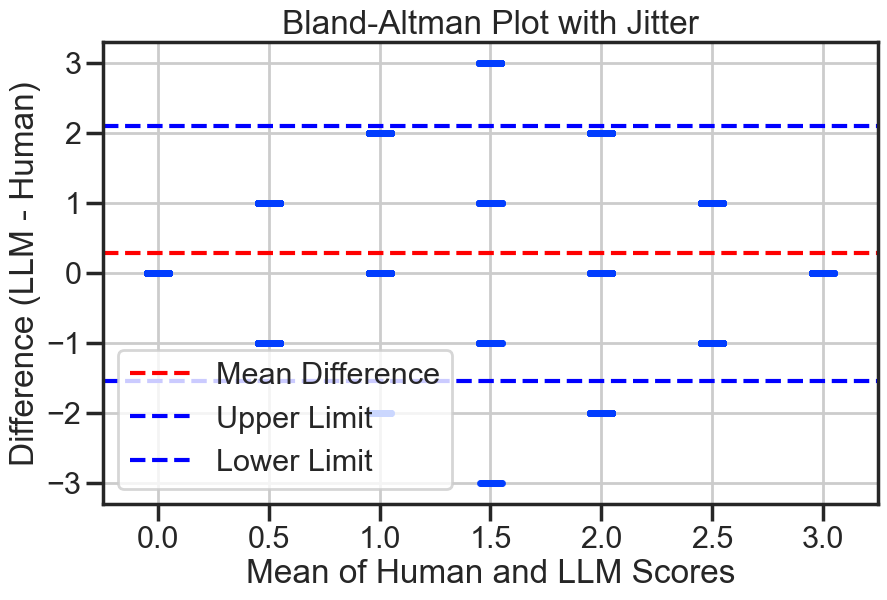

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example data: replace with your actual scores
# human_scores = np.array([/* human scores */])
# llm_scores = np.array([/* llm scores */])
human_scores = nist_qrels['rel']
llm_scores = gpt4_qrels['rel']

# Calculate mean scores and differences
mean_scores = (human_scores + llm_scores) / 2
differences = llm_scores - human_scores

# Plot using seaborn to add jitter
plt.figure(figsize=(10, 6))
sns.stripplot(x=mean_scores, y=differences, jitter=True, alpha=0.9)
plt.axhline(np.mean(differences), color='red', linestyle='--', label='Mean Difference')
plt.axhline(np.mean(differences) + 1.96 * np.std(differences), color='blue', linestyle='--', label='Upper Limit')
plt.axhline(np.mean(differences) - 1.96 * np.std(differences), color='blue', linestyle='--', label='Lower Limit')
plt.xlabel('Mean of Human and LLM Scores')
plt.ylabel('Difference (LLM - Human)')
plt.title('Bland-Altman Plot with Jitter')
plt.legend()
plt.grid(True)
plt.show()

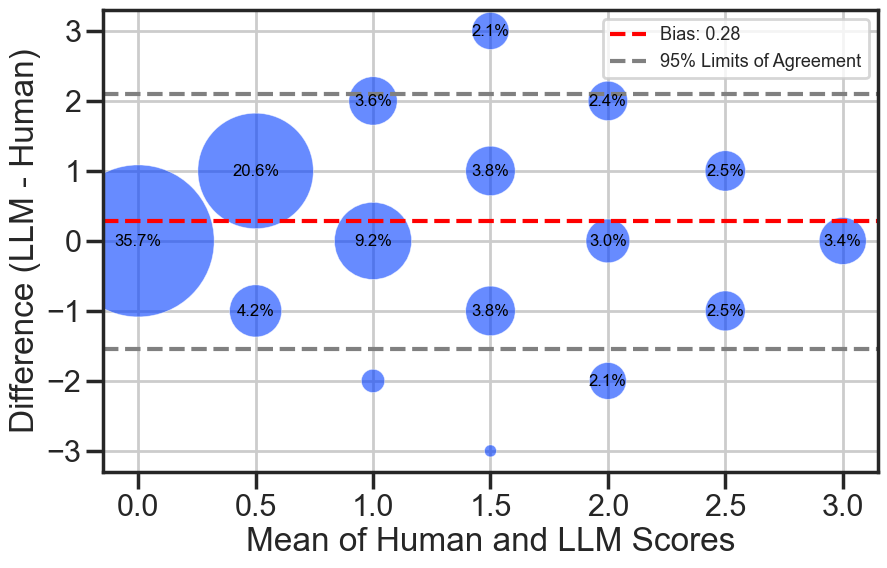

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Example data: replace with your actual scores
# human_scores = np.array([/* human scores */])
# llm_scores = np.array([/* llm scores */])

# Calculate mean scores and differences
mean_scores = (human_scores + llm_scores) / 2
differences = llm_scores - human_scores

# Combine mean scores and differences into tuples for counting
points = list(zip(mean_scores, differences))

# Count the frequency of each unique point
point_counts = Counter(points)

# Extract unique points and their counts
unique_points = np.array(list(point_counts.keys()))
frequencies = np.array(list(point_counts.values()))

# Calculate percentages
total_points = len(points)
percentages = (frequencies / total_points) * 100

# Create Bland-Altman plot with point sizes indicating density
plt.figure(figsize=(10, 6))

# Scatter plot with point size based on frequency
plt.scatter(unique_points[:, 0], unique_points[:, 1], s=frequencies * 1.5, alpha=0.6, edgecolors='w', linewidth=0.5)

# Optionally add text annotations for percentage
for (x, y), percentage in zip(unique_points, percentages):
    if percentage > 1:  # Only annotate if the percentage is greater than 1%
        plt.text(x, y, f'{percentage:.1f}%', fontsize=12, ha='center', va='center', color='black')

# Add lines for mean difference and limits of agreement
mean_diff = np.mean(differences)
std_diff = np.std(differences)
# plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
# plt.axhline(mean_diff + 1.96 * std_diff, color='blue', linestyle='--', label='Upper Limit')
# plt.axhline(mean_diff - 1.96 * std_diff, color='blue', linestyle='--', label='Lower Limit')

plt.axhline(mean_diff, color='red', linestyle='--', label=f'Bias: {mean_diff:.2f}')
plt.axhline(mean_diff + 1.96*std_diff, color='gray', linestyle='--', label='95% Limits of Agreement')
plt.axhline(mean_diff - 1.96*std_diff, color='gray', linestyle='--')

plt.xlabel('Mean of Human and LLM Scores')
plt.ylabel('Difference (LLM - Human)')
# plt.title('Bland-Altman Plot with Point Density Indication')
plt.legend(fontsize=13)
plt.grid(True)
plt.savefig("figs/bland_altman_plot_scores_with_precentage.pdf", bbox_inches="tight")
# plt.show()